`Proyecto IEE3031- Ignacio Moraga Silva`

In [1]:
import pandas as pd
import matplotlib.pyplot as plt
from matplotlib.patches import Patch
import seaborn as sns
import numpy as np

from sklearn.model_selection import train_test_split, cross_validate, StratifiedKFold
from sklearn.preprocessing import StandardScaler, OneHotEncoder
from sklearn.compose import ColumnTransformer

from sklearn.pipeline import Pipeline
from sklearn.linear_model import LogisticRegression
from xgboost import XGBClassifier
from sklearn.neural_network import MLPClassifier

from sklearn.metrics import roc_auc_score
from sklearn.metrics import classification_report, confusion_matrix, ConfusionMatrixDisplay

from sklearn.base import BaseEstimator, TransformerMixin

from imblearn.over_sampling import SMOTE
from imblearn.pipeline import Pipeline as ImbPipeline

Importamos el dataset y lo procesamos en cuanto a los inputs (22) que realmente vamos a usar y la transformación del target (3 clases a binario):

Dimensiones del dataset original: (4424, 35)

Balance original:
Target
Graduate    2209
Dropout     1421
Enrolled     794
Name: count, dtype: int64

DATASET PROCESADO
Dimensiones: (4424, 23)
Columnas seleccionadas: 22

BALANCE DE CLASES - Target Binario
Conteo absoluto:
Clase 0 (Enrolled + Graduate): 3003
Clase 1 (Dropout): 1421

Porcentajes:
Clase 0 (Enrolled + Graduate): 67.88%
Clase 1 (Dropout): 32.12%



C:\Users\ignac\AppData\Local\Temp\ipykernel_14260\1472983486.py:67: UserWarning: set_ticklabels() should only be used with a fixed number of ticks, i.e. after set_ticks() or using a FixedLocator.
  axes[0].set_xticklabels(class_labels)


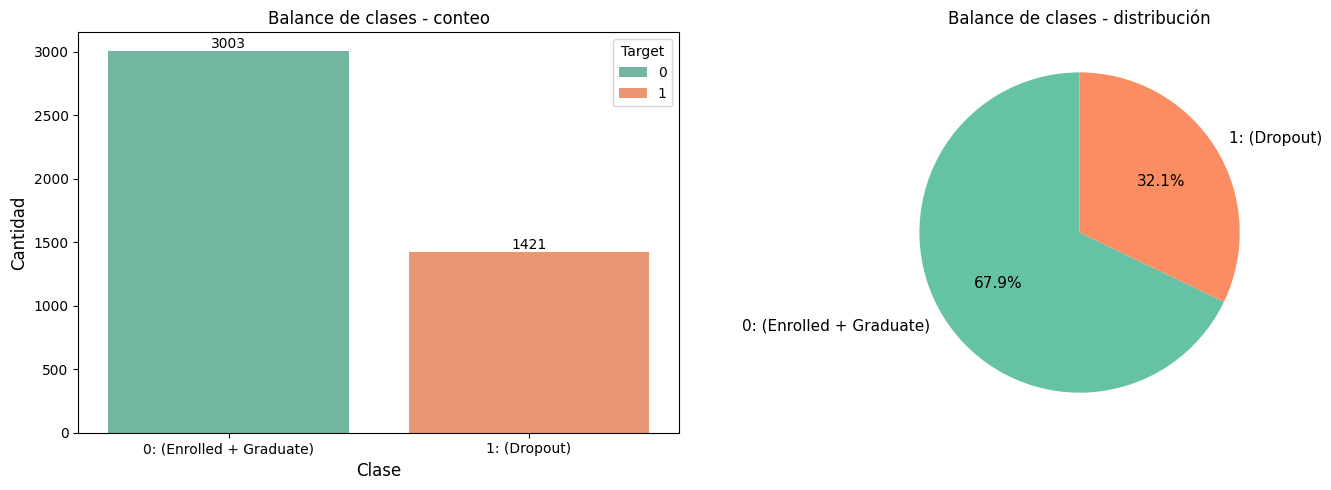


Dimensiones de X: (4424, 22)
Distribución del Target: 
Target
0    0.678797
1    0.321203
Name: proportion, dtype: float64

Muestras para Train + Val (CV): 3539
Muestras para Test: 885


In [2]:
SEED = 123
data_path = r"DATA\Proyecto_IEE3031_dataset.csv"
df = pd.read_csv(data_path) 

print(f"Dimensiones del dataset original: {df.shape}")
print(f"\nBalance original:")
print(df["Target"].value_counts())

# Seleccionamos las columnas de interés
columnas_input = [
    "Marital status",
    "Nacionality",  
    "Displaced",
    "Gender",
    "Age at enrollment",
    "International",
    "Mother's qualification",
    "Father's qualification",
    "Mother's occupation",
    "Father's occupation",
    "Educational special needs",
    "Scholarship holder",
    "Unemployment rate",
    "Inflation rate",
    "GDP",
    "Application mode",
    "Application order",
    "Course",
    "Daytime/evening attendance",
    "Previous qualification",
    "Curricular units 1st sem (credited)",
    "Curricular units 1st sem (enrolled)"]

# Creamos el dataset con las columnas seleccionadas + Target
df_selected = df[columnas_input + ["Target"]].copy()

# Transformamos Target a binario: 0 = Enrolled/Graduate, 1 = Dropout
df_selected["Target"] = df_selected["Target"].apply(lambda x: 1 if x == "Dropout" else 0)

# ------------------------------------------------------------------------------------------------------------------------------ #
print(f"\n{"="*60}")
print("DATASET PROCESADO")
print(f"{"="*60}")
print(f"Dimensiones: {df_selected.shape}")
print(f"Columnas seleccionadas: {len(columnas_input)}")

print(f"\n{"="*60}")
print("BALANCE DE CLASES - Target Binario")
print(f"{"="*60}")
class_counts = df_selected["Target"].value_counts().sort_index()
print(f"Conteo absoluto:")
print(f"Clase 0 (Enrolled + Graduate): {class_counts[0]}")
print(f"Clase 1 (Dropout): {class_counts[1]}")

print(f"\nPorcentajes:")
class_percentages = df_selected["Target"].value_counts(normalize=True).sort_index() * 100
print(f"Clase 0 (Enrolled + Graduate): {class_percentages[0]:.2f}%")
print(f"Clase 1 (Dropout): {class_percentages[1]:.2f}%\n")

# Plots de balance de clases
fig, axes = plt.subplots(1, 2, figsize = (14, 5))
class_labels = ["0: (Enrolled + Graduate)", "1: (Dropout)"]
sns.countplot(data = df_selected, x = "Target", ax = axes[0], hue = "Target", palette = "Set2", order = [0, 1])
axes[0].set_title("Balance de clases - conteo")
axes[0].set_xlabel("Clase", fontsize = 12)
axes[0].set_ylabel("Cantidad", fontsize = 12)
axes[0].set_xticklabels(class_labels)

for container in axes[0].containers:
    axes[0].bar_label(container, fontsize = 10)

colors = sns.color_palette("Set2", n_colors = 2)
axes[1].pie(class_counts, labels = class_labels, autopct = "%1.1f%%", 
            startangle = 90, colors = colors, textprops = {"fontsize": 11})
axes[1].set_title("Balance de clases - distribución")
plt.tight_layout()
plt.savefig("balance_clases_target.jpg", dpi = 600)
plt.show()
plt.close()

# ------------------------------------------------------------------------------------------------------------------------------ #
# Separamos características de objetivo
X = df_selected.drop("Target", axis=1)
y = df_selected["Target"]
print(f"\nDimensiones de X: {X.shape}")
print(f"Distribución del Target: \n{y.value_counts(normalize = True)}")

# División en conjunto Train + Validation y conjunto de Test
# Usamos stratify = y para que ambos conjuntos tengan un % similar de deserción.
# test_size = 0.2 = 20% para la evaluación final
X_train_val, X_test, y_train_val, y_test = train_test_split(X, y, test_size = 0.2, random_state = SEED, stratify = y)
print(f"\nMuestras para Train + Val (CV): {X_train_val.shape[0]}")
print(f"Muestras para Test: {X_test.shape[0]}")

In [ ]:
# Vemos la fefinición de columnas según su tipo
numerical_features = [
    "Application order", 
    "Age at enrollment", 
    "Curricular units 1st sem (credited)", 
    "Curricular units 1st sem (enrolled)", 
    "Unemployment rate", 
    "Inflation rate", 
    "GDP"]

categorical_features = [
    "Marital status", 
    "Application mode", 
    "Course", 
    "Daytime/evening attendance", 
    "Previous qualification", 
    "Nacionality", 
    "Mother's qualification", 
    "Father's qualification", 
    "Mother's occupation", 
    "Father's occupation", 
    "Displaced", 
    "Educational special needs", 
    "Gender", 
    "Scholarship holder", 
    "International"]

rare_label_tol = 0.02

# La idea es crear una clase que agrupe las categorías raras (baja frecuencia) en "Other"
# Para ello transformamos las columnas categóricas antes de aplicar OneHotEncoding
class RareLabelEncoder(BaseEstimator, TransformerMixin):
    def __init__(self, variables, tol):
        self.variables = variables # lista de columnas categóricas a procesar
        self.tol = tol # frecuencia mínima (porcentaje) para mantener una categoría
        self.frequent_labels_dict = {}

    def fit(self, X, y = None):
        # Aprendemos cuáles son las etiquetas frecuentes basándonos SOLO en el set de training
        for var in self.variables:
            t = pd.Series(X[var]).value_counts(normalize = True)
            # print(f"Frecuencia: {t}")
            self.frequent_labels_dict[var] = list(t[t >= self.tol].index)
            # Si es menor a tol = X, se agrupa en "Other"
            # X significa que categorías con menos del X % de los datos se vuelven "Other"
        return self

    def transform(self, X):
        X = X.copy()
        if isinstance(X, np.ndarray):
            X = pd.DataFrame(X, columns = self.variables)
            
        for var in self.variables:
            # Todo lo que no esté en la lista frecuente se reemplaza por "Other"
            X[var] = np.where(X[var].isin(self.frequent_labels_dict[var]), X[var], "Other")
        return X
    
# Pipeline específico para variables categóricas
categorical_transformer = Pipeline(steps = [
    # 1. Agrupación de categorías "raras" (menos del self.tol % de frecuencia) en "Other"
    ("rare_label_encoder", RareLabelEncoder(variables = categorical_features, tol = rare_label_tol)),
    # 2. Ahora aplicamos OneHotEncoding
    # handle_unknown = "ignore" por seguridad
    ("onehot", OneHotEncoder(drop = "if_binary", handle_unknown = "ignore"))])

# Preprocesador general
# StandardScaler: Se ajusta solo con el fold de entrenamiento
preprocessor = ColumnTransformer(transformers = [("num", StandardScaler(), numerical_features), 
                                                 ("cat", categorical_transformer, categorical_features)])

In [ ]:
# Sin transformación de columnas con RareLabelEncoder
categorical_transformer_simple = OneHotEncoder(drop = "if_binary", handle_unknown = "ignore")

preprocessor_simple = ColumnTransformer(transformers=[("num", StandardScaler(), numerical_features), 
                                                      ("cat", categorical_transformer_simple, categorical_features)])
preprocessor_simple.fit(X_train_val, y_train_val)
n_features_sin_rare = preprocessor_simple.transform(X_train_val).shape[1]
print(f"Dimensiones del espacio de características SIN RareLabelEncoder: {n_features_sin_rare}")

# Con transformación de columnas con RareLabelEncoder
preprocessor.fit(X_train_val, y_train_val)
n_features_con_rare = preprocessor.transform(X_train_val).shape[1]
print(f"Dimensiones del espacio de características CON RareLabelEncoder: {n_features_con_rare}")

Dimensiones del espacio de características SIN RareLabelEncoder: 221
Dimensiones del espacio de características CON RareLabelEncoder: 83


Pipelines para modelos y CV:

In [5]:
def logistic_regression_pipeline(seed, preprocessor):
    model = LogisticRegression(
        penalty = "l2", 
        C = 0.5, 
        solver = "lbfgs", 
        max_iter = 500, 
        random_state = seed,
        class_weight = "balanced"  # Para manejar clases desbalanceadas
    )
    return Pipeline([("preprocessor", preprocessor), ("classifier", model)])

def xgboost_pipeline(seed, preprocessor):
    model = XGBClassifier(
        objective = "binary:logistic",
        eval_metric = "logloss",
        random_state = seed,
        max_depth = 8,
        reg_lambda = 2.5,
        scale_pos_weight = float(3003/1421),  # Ajuste para clases desbalanceadas
        # scale_pos_weight = sum(negative instances) / sum(positive instances)
        n_jobs = -1  # Usa todos los núcleos disponibles
    )
    return Pipeline([("preprocessor", preprocessor), ("classifier", model)])

# SMOTE PARA MLP al no tener balance de clases:
def mlp_pipeline_balanced(seed, preprocessor):
    """
    Pipeline para MLP con Synthetic Minority Over-sampling Technique (SMOTE).
    Se usa ImbPipeline para asegurar que el oversampling solo ocurra en el entrenamiento.
    """
    model = MLPClassifier(
        hidden_layer_sizes = (64,), 
        activation = "relu", 
        solver  = "adam", 
        alpha = 0.001,
        max_iter = 500,
        early_stopping = True,
        random_state = seed)
    
    # El orden es importante: 
    # 1. Preprocesamiento (OneHot/Estandarizacion) -> Transformamos todo a números
    # 2. SMOTE -> Genera data sintética para balancear clases
    # 3. Clasificador -> Entrena con la nueva data balanceada
    return ImbPipeline([("preprocessor", preprocessor), ("smote", SMOTE(random_state = seed)), 
                        ("classifier", model)])

def cv_train(X, y, k_splits, seed, model_pipeline, model_name):
    """
    Validación cruzada estratificada y reporte de métricas.
    """
    # StratifiedKFold para que la proporción de dropouts se mantenga en cada fold
    kf = StratifiedKFold(n_splits = k_splits, shuffle = True, random_state = seed)

    # Métricas a evaluar
    scoring_metrics = {
    "accuracy": "accuracy",
    "roc_auc": "roc_auc",
    "f1_macro": "f1_macro",
    "recall": "recall", # Sensibilidad (Detectar Desertores)
    "neg_log_loss": "neg_log_loss",
    "precision": "precision"}

    print("-" * 60)
    print(f"Evaluando modelo: < {model_name} >")
    print("-" * 60)
    
    # n_jobs = -1 permite paralelizar los folds
    cv_results = cross_validate(model_pipeline, X, y, cv = kf, scoring = scoring_metrics, n_jobs = -1)

    metrics_dict = {}
    print(f"Resultados promedio en validación ({k_splits} folds):")

    for metric_name in scoring_metrics.keys():
        key = f"test_{metric_name}"
        mean_score = cv_results[key].mean()
        std_score = cv_results[key].std()
        print(f"{metric_name.capitalize()}: {mean_score:.4f} (± {std_score:.4f})")
        metrics_dict[metric_name] = f"{mean_score:.4f} (± {std_score:.4f})"
    
    print("-" * 60)
    return metrics_dict

In [6]:
K_SPLITS = 5

# 1. Regresión Logística
rl_pipe = logistic_regression_pipeline(SEED, preprocessor)
rl_metrics = cv_train(X_train_val, y_train_val, K_SPLITS, SEED, rl_pipe, "Regresión Logística")

# 2. Gradient Boosting (XGBoost)
xgb_pipe = xgboost_pipeline(SEED, preprocessor)
xgb_metrics = cv_train(X_train_val, y_train_val, K_SPLITS, SEED, xgb_pipe, "XGBoost (Gradient Boosting)")

# 3. Red Neuronal (MLP)
mlp_pipe = mlp_pipeline_balanced(SEED, preprocessor) # mlp_pipeline(SEED, preprocessor)
mlp_metrics = cv_train(X_train_val, y_train_val, K_SPLITS, SEED, mlp_pipe, "Perceptrón Multicapa (MLP)")

------------------------------------------------------------
Evaluando modelo: < Regresión Logística >
------------------------------------------------------------
Resultados promedio en validación (5 folds):
Accuracy: 0.6937 (± 0.0339)
Roc_auc: 0.7617 (± 0.0294)
F1_macro: 0.6734 (± 0.0339)
Recall: 0.6905 (± 0.0382)
Neg_log_loss: -0.5798 (± 0.0262)
Precision: 0.5189 (± 0.0409)
------------------------------------------------------------
------------------------------------------------------------
Evaluando modelo: < XGBoost (Gradient Boosting) >
------------------------------------------------------------
Resultados promedio en validación (5 folds):
Accuracy: 0.7090 (± 0.0281)
Roc_auc: 0.7481 (± 0.0277)
F1_macro: 0.6662 (± 0.0287)
Recall: 0.5462 (± 0.0348)
Neg_log_loss: -0.6279 (± 0.0489)
Precision: 0.5492 (± 0.0444)
------------------------------------------------------------
------------------------------------------------------------
Evaluando modelo: < Perceptrón Multicapa (MLP) >


Nos quedamos con el modelo de mayor recall (es la métrica más importante para el proyecto)


EVALUACIÓN FINAL EN SET DE TEST: Regresión Logística
Reporte de clasificación en set de test:
               precision    recall  f1-score   support

Enrolled/Grad       0.83      0.67      0.74       601
      Dropout       0.50      0.71      0.59       284

     accuracy                           0.68       885
    macro avg       0.67      0.69      0.67       885
 weighted avg       0.73      0.68      0.69       885

AUC-ROC: 0.7754


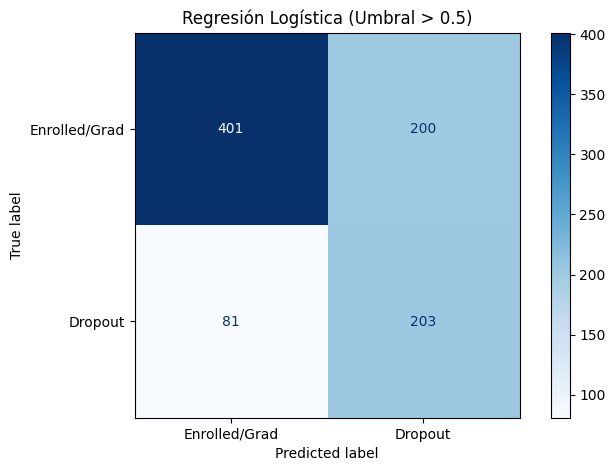

In [7]:
def evaluate_on_test(pipeline, X_train, y_train, X_test, y_test, model_name, threshold):
    print(f"\n{"="*60}")
    print(f"EVALUACIÓN FINAL EN SET DE TEST: {model_name}")
    print(f"{"="*60}")
    
    # Re-entrenamos el pipeline con el set de entrenamiento porque cross-validate no deja el modelo entrenado 
    # listo para usar, solo lo evalúa
    pipeline.fit(X_train, y_train)
    
    y_proba = pipeline.predict_proba(X_test)[:, 1] # de la clase positiva
    
    y_pred = (y_proba >= threshold).astype(int)
    
    print("Reporte de clasificación en set de test:")
    target_names = ["Enrolled/Grad", "Dropout"]
    print(classification_report(y_test, y_pred, digits = 2, target_names = target_names))

    auc = roc_auc_score(y_test, y_proba)
    print(f"AUC-ROC: {auc:.4f}")
    
    cm = confusion_matrix(y_test, y_pred)
    # In binary classification:
    # true negatives is :math:`C_{0,0}`
    # false positives is :math:`C_{0,1}`.
    # false negatives is :math:`C_{1,0}`
    # true positives is :math:`C_{1,1}`
    disp = ConfusionMatrixDisplay(confusion_matrix = cm, display_labels = ["Enrolled/Grad", "Dropout"])
    
    fig, ax = plt.subplots(figsize = (8, 5))
    disp.plot(cmap = "Blues", ax = ax, values_format = "d", colorbar = True)
    plt.title(f"{model_name} (Umbral > {threshold})")
    plt.grid(False)
    plt.savefig(f"{model_name}_threshold_{threshold}.jpg", dpi = 600)
    plt.show()
    plt.close()
    
    return fig

# # 1. Regresión Logística
cm1 = evaluate_on_test(rl_pipe, X_train_val, y_train_val, X_test, y_test, "Regresión Logística", 0.5)
# # 2. XGBoost
# cm2 = evaluate_on_test(xgb_pipe, X_train_val, y_train_val, X_test, y_test, "XGBoost", 0.5)
# # # 3. Multi-Layer Perceptron
# cm3 = evaluate_on_test(mlp_pipe, X_train_val, y_train_val, X_test, y_test, "MLP (Red Neuronal)", 0.5)

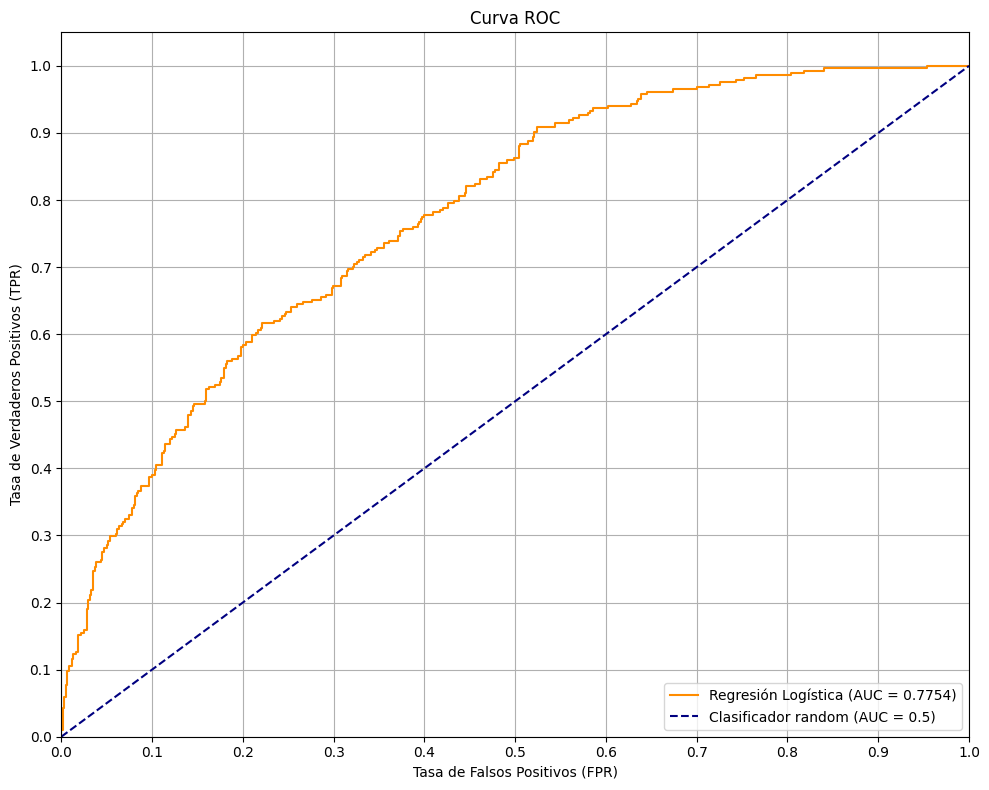

In [8]:
from sklearn.metrics import roc_curve, auc

def plot_roc_comparison(models_dict, X_train, y_train, X_test, y_test):

    plt.figure(figsize = (10, 8))
    colors = ["darkorange", "green", "red", "purple", "brown"]
    
    for i, (model_name, pipeline) in enumerate(models_dict.items()):
        pipeline.fit(X_train, y_train)
        y_proba = pipeline.predict_proba(X_test)[:, 1]
        
        fpr, tpr, _ = roc_curve(y_test, y_proba)
        roc_auc = auc(fpr, tpr)
        
        plt.plot(fpr, tpr, color = colors[i % len(colors)], label = f"{model_name} (AUC = {roc_auc:.4f})")

    # Diagonal (clasificador aleatorio)
    plt.plot([0, 1], [0, 1], color = "navy", linestyle = "--", label = "Clasificador random (AUC = 0.5)")
    plt.xlim([0.0, 1.0])
    plt.ylim([0.0, 1.05])
    plt.xlabel("Tasa de Falsos Positivos (FPR)")
    plt.ylabel("Tasa de Verdaderos Positivos (TPR)")
    plt.xticks(ticks = np.arange(0, 1.1, 0.1))
    plt.yticks(ticks = np.arange(0, 1.1, 0.1))
    plt.title("Curva ROC")
    plt.legend(loc = "lower right")
    plt.grid()
    plt.tight_layout()
    plt.savefig("roc_comparison.jpg", dpi = 600)
    plt.show()
    plt.close()

# Comparacion de todos los modelos
# models = {"Regresión Logística": rl_pipe,
#           "XGBoost": xgb_pipe,
#           "MLP (Red Neuronal)": mlp_pipeline_balanced(SEED, preprocessor)}

models = {"Regresión Logística": rl_pipe}

plot_roc_comparison(models, X_train_val, y_train_val, X_test, y_test)


 Importancia de características para: Regresión Logística


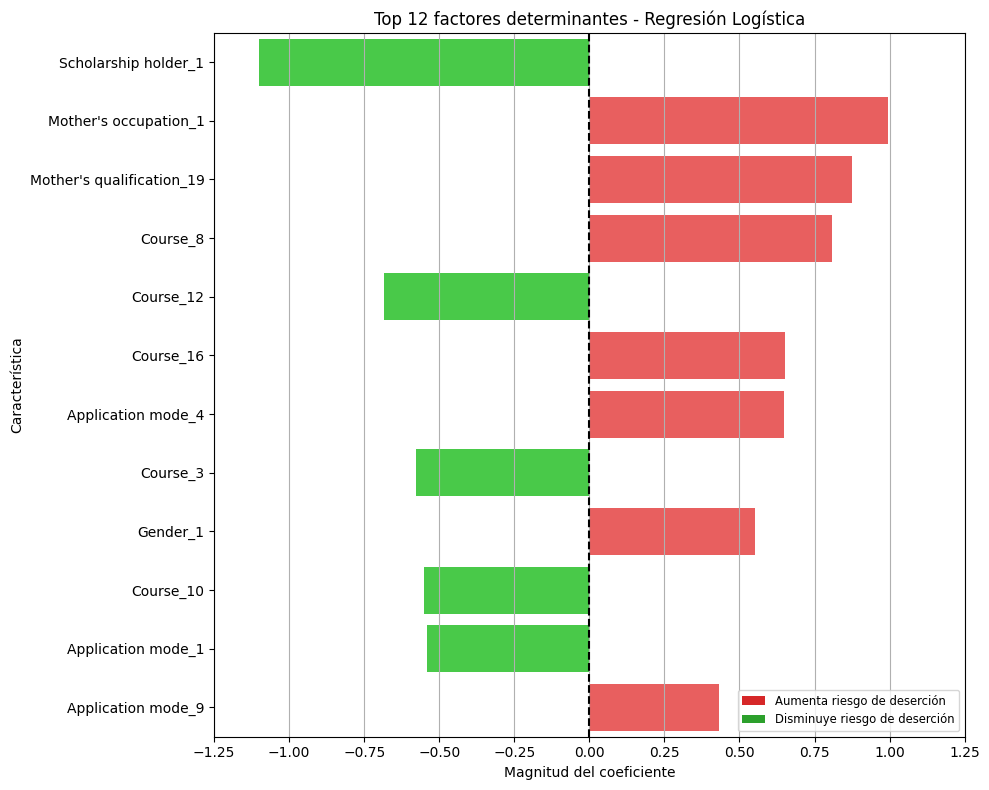


FACTORES DE 'RIESGO' (5 más importantes)
Nota: Odds Ratio > 1 indica AUMENTO de riesgo
      Ej: Odds Ratio de 2.5 significa 2.5 veces más riesgo
--------------------------------------------------
                  Feature  Coefficient  Odds_Ratio
    Mother's occupation_1       0.9960      2.7073
Mother's qualification_19       0.8760      2.4014
                 Course_8       0.8078      2.2430
                Course_16       0.6511      1.9177
       Application mode_4       0.6484      1.9124

FACTORES 'PROTECTORES' (5 más importantes)
Nota: Odds Ratio < 1 indica DISMINUCIÓN de riesgo
      Ej: Odds Ratio de 0.40 significa que el riesgo baja en un 60%
--------------------------------------------------
             Feature  Coefficient  Odds_Ratio
Scholarship holder_1      -1.0997      0.3330
           Course_12      -0.6839      0.5046
            Course_3      -0.5773      0.5614
           Course_10      -0.5518      0.5759
  Application mode_1      -0.5400      0.5827


In [9]:
top_n = 12

def plot_feature_importance(pipeline, model_name, top_n = top_n):
    print(f"\n Importancia de características para: {model_name}")
    # El modelo debe estar entrenado en todo el set de entrenamiento
    pipeline.fit(X_train_val, y_train_val)
    
    classifier = pipeline.named_steps["classifier"]
    preprocessor = pipeline.named_steps["preprocessor"]

    # Features numéricas
    num_names = numerical_features
    
    # Features categóricas
    # Necesitamos entrar al transformador "cat" -> "onehot"
    ohe_step = preprocessor.named_transformers_["cat"].named_steps["onehot"]
    # Obtenemos los nombres generados por onehot
    cat_names = list(ohe_step.get_feature_names_out(input_features = categorical_features))
    # input_features = categorical_features garantiza que los nombres coincidan con las columnas que generó el 
    # onehot, incluso si algunas categorías se eliminaron con drop = "if_binary"

    feature_names = num_names + cat_names
    
    # Coeficientes (Log-Odds)
    coeffs = classifier.coef_[0] # coef_[0] es para la clase 1 (Dropout) en clasificación binaria
    # Un coeficiente positivo en coef_[0] significa que al aumentar esa variable aumenta la probabilidad de ser 
    # Clase 1 (Desertar)
    # Un coeficiente negativo en coef_[0] significa que, al aumentar esa variable, disminuye la probabilidad de ser 
    # Clase 1 (o aumenta la de ser Clase 0)

    # Odds Ratios (e^coeficiente)
    odds_ratios = np.exp(coeffs)
    
    df_coeffs = pd.DataFrame({"Feature": feature_names, 
                              "Coefficient": coeffs, 
                              "Abs_Coefficient": np.abs(coeffs), 
                              "Odds_Ratio": odds_ratios})
    
    df_coeffs = df_coeffs.sort_values(by = "Abs_Coefficient", ascending = False)
    
    df_top = df_coeffs.head(top_n).copy()
    
    # Ploteo
    plt.figure(figsize = (10, 8))
    colors = ["#ff4848" if c > 0 else "#33df33" for c in df_top["Coefficient"]]
    sns.barplot(data = df_top, x = "Coefficient", y = "Feature", hue = "Feature", palette = colors, legend = False)
    plt.title(f"Top {top_n} factores determinantes - {model_name}")
    plt.xlabel("Magnitud del coeficiente")
    plt.ylabel("Característica")
    plt.axvline(x = 0, color = "black", linestyle = "--")

    legend_elements = [Patch(facecolor = "#d62728", label = "Aumenta riesgo de deserción"), 
                       Patch(facecolor = "#2ca02c", label = "Disminuye riesgo de deserción")]
    
    plt.legend(handles = legend_elements, loc = "lower right", fontsize = "small")
    plt.xticks(ticks = np.arange(-1.25, 1.5, 0.25))
    plt.grid(axis = "x")
    plt.tight_layout()
    plt.savefig(f"{model_name}_feature_importance.jpg", dpi = 600)
    plt.show()
    plt.close()
    
    return df_coeffs

df_importance = plot_feature_importance(rl_pipe, "Regresión Logística")

pd.set_option("display.float_format", lambda x: "%.4f" % x)

print(f"\n{"="*50}")
print(f"FACTORES DE 'RIESGO' ({5} más importantes)")
print(f"{"="*50}")
print("Nota: Odds Ratio > 1 indica AUMENTO de riesgo")
print("      Ej: Odds Ratio de 2.5 significa 2.5 veces más riesgo")
print("-" * 50)
cols_show = ["Feature", "Coefficient", "Odds_Ratio"]
print(df_importance[df_importance["Coefficient"] > 0].head(5)[cols_show].to_string(index = False))

print(f"\n{"="*50}")
print(f"FACTORES 'PROTECTORES' ({5} más importantes)")
print(f"{"="*50}")
print("Nota: Odds Ratio < 1 indica DISMINUCIÓN de riesgo")
print("      Ej: Odds Ratio de 0.40 significa que el riesgo baja en un 60%")
print("-" * 50) 
print(df_importance[df_importance["Coefficient"] < 0].head(5)[cols_show].to_string(index = False))